In [102]:
from os import path
if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    !wget https://biolab.csr.unibo.it/samples/fr/files.zip
    !unzip files.zip
    
    
import utils  # Run utils.py for helper functions
import fingerprint as fp
import math
import os
import importlib
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import PyQt5.QtWidgets as qtw
from utils import *
from ipywidgets import interact

%cd /workspaces/fingerprint/

/workspaces/fingerprint


In [103]:
importlib.reload(fp)

<module 'fingerprint' from '/workspaces/fingerprint/A2/fingerprint.py'>

Gx**2 102_5.tif,Gy**2 of 102_5.tif,Gradient Magnitude 102_5.tif
,,

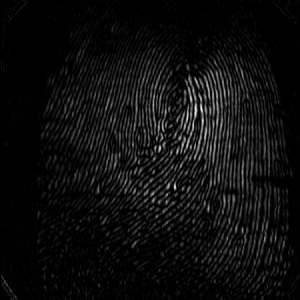
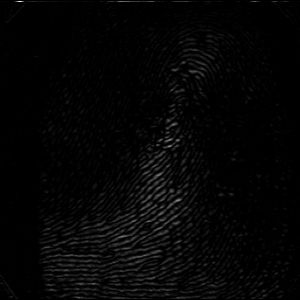
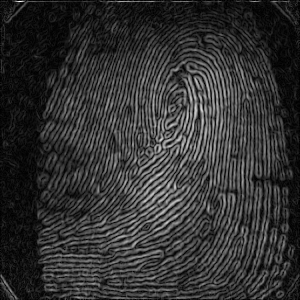

In [104]:
#Show the resultant image for the first element of the database
readFingerPrints = fp.read_fingerprints()
GxList, GyList, Gx2List, Gy2List, GmList = fp.calc_sobel(readFingerPrints)
_, filename = readFingerPrints[0]

show((Gx2List[0], f'Gx**2 {filename}'), (Gy2List[0], f'Gy**2 of {filename}'), (GmList[0], f'Gradient Magnitude {filename}'))

Integral of the Gradient Magnitude of 102_5.tif
""

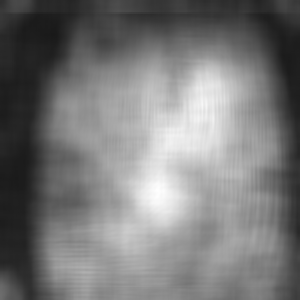

In [105]:
# Integral over a square window for 102_5.tif
sumGm = fp.sum_Gm(GmList)

show(sumGm[0], f'Integral of the Gradient Magnitude of {filename}')

Original Image of 102_5.tif,Threshold Mask of 102_5.tif,Mask Backprojected to the Original Image of 102_5.tif
,,

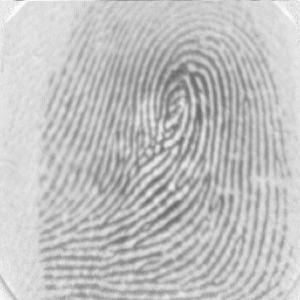
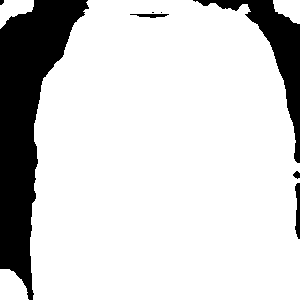
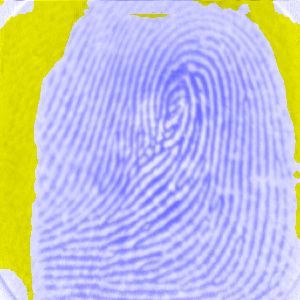

In [106]:
# Simple thresholding for segmenting the fingerprint pattern

thres = fp.threshold_mask(sumGm)
show((readFingerPrints[0][0], f'Original Image of {filename}'), (thres[0], f'Threshold Mask of {filename}'), (cv.merge((thres[0], readFingerPrints[0][0], readFingerPrints[0][0])), f'Mask Backprojected to the Original Image of {filename}'))


Orientation Image 102_5.tif
""

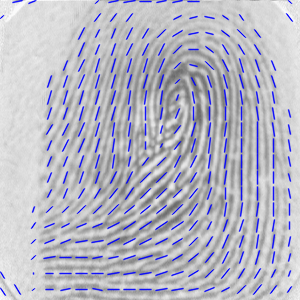

In [107]:
orientationsList, strengthsList = fp.ridge_orientation(GxList, GyList, Gx2List, Gy2List)
show((draw_orientations(readFingerPrints[0][0], orientationsList[0], strengthsList[0], thres[0], 1, 16)), f'Orientation Image {filename}')

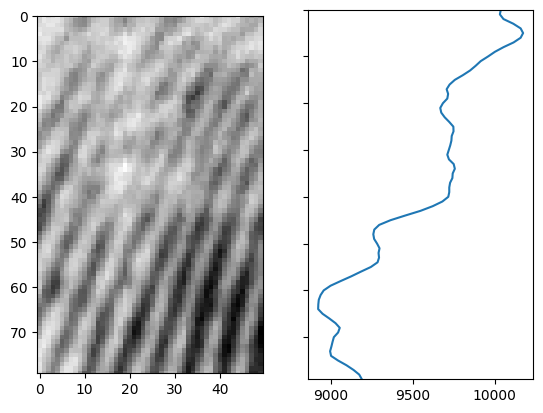

In [113]:
regionList, blurRegionList, xSigList = fp.ridge_frequency(readFingerPrints)

x = np.arange(regionList[0].shape[0])
f, axarr = plt.subplots(1, 2, sharey = True)
axarr[0].imshow(regionList[0], cmap = 'gray')
axarr[1].plot(xSigList[0], x)
axarr[1].set_ylim(regionList[0].shape[0] - 1, 0)
plt.show()